# Import

In [24]:
import io
import zipfile
import urllib.request
from datetime import datetime
import requests
from bs4 import BeautifulSoup
import pandas as pd
import MeCab
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
from gensim import corpora, matutils

## Webページをダウンロード

In [11]:
url = 'https://www.seshop.com/'
r = requests.get(url)
'''
各ステータスの確認

print(type(r))
print(r.status_code)
'''

# htmlのソースを取得
text = r.text
for line in text.split('\n'):
    if '<title>' in line or '<h2>' in line:
        # 余分な空白を削除し確認しやすくするためにstrip()を使用
        print(line.strip())

<title>SEshop｜ 翔泳社の本・電子書籍通販サイト</title>
<h2>予約ランキング</h2>
<h2>書籍ランキング <span class="pull-right"><a href="/ranking/1"><span class="glyphicon glyphicon-chevron-right"></span> もっと見る</a></span></h2>
<h2>電子書籍ランキング<span class="pull-right"><a href="/ranking/327/"><span class="glyphicon glyphicon-chevron-right"></span> もっと見る</a></span></h2>
<h2>新刊案内</h2>
<h2>申し込み受付中のセミナー</h2>
<h2>商品カテゴリー</h2>
<h2>人気商品ランキング</h2>
<h2>キャンペーン・特集</h2>


## Webページから要素を抜き出す

In [15]:
# htmlを解析したBeautifulSourpオブジェクトを生成
soup = BeautifulSoup(text,'html.parser')
# <title>タグの表示
print(soup.title)
# <h2>タグの表示
print(soup.h2)

# <h2>タグをすべて取得
h2_tags = soup.find_all('h2')

for h2 in h2_tags:
    # 各<h2>タグ内の<a>タグを探す
    a_tag = h2.find('a')
    # print(a_tag)
    # <a>タグが存在し、href属性を持っている場合、そのhref属性を表示
    if a_tag and a_tag.has_attr('href'):
        print(a_tag['href'])

<title>SEshop｜ 翔泳社の本・電子書籍通販サイト</title>
<h2>予約ランキング</h2>
/ranking/1
/ranking/327/


In [17]:
a_tags = soup.find_all('a')
print(len(a_tags))

226


In [18]:
for a_tag in a_tags[:5]:
    print(f'タイトル:{a_tag.text}')
    print(f'リンク:{a_tag["href"]}')

タイトル: ヘルプ
リンク:/help
タイトル: 新規会員登録
リンク:https://www.seshop.com/regist/
タイトル: ログイン
リンク:#modalLogin
タイトル:
リンク:/
タイトル:お気に入り
リンク:#modalLogin


## Webページの書籍一覧から要素を取得しdfにする

In [ ]:
url = 'https://www.seshop.com/product/616'
r = requests.get(url)
soup = BeautifulSoup(r.text, 'html.parser')
# CSSセレクターで<div class="list">の中の<div class="inner">を取得
divs = soup.select("div.list div.inner")
print(f"divタグの数:{len(divs)}")

books = []
for div in divs:
    # 画像のURLを取得
    img_url = div.find("img")["src"]
    
    # 日付の文字列を取得
    day = div.find("span", class_="date").text.strip()
    #? 元々の発売日を消す
    day = day.replace("発売", "")
    # 日付をdatetimeへ変換
    published_day = datetime.strptime(day,"%Y.%m.%d")
    
    # 書籍のURLを取得
    div_text = div.find("div", class_="txt")
    a_tag = div_text.find("a")
    url = a_tag["href"]
    
    # 書籍のタイトルを取得
    title = a_tag.text
    
    # 販売価格を取得
    price_tags = div_text.find_all("p")
    if len(price_tags) > 1:
        price_s = price_tags[1].text.strip()
    else:
        price_s = "価格情報が見つかりません"
    # 不要な文字列の削除
    price_s = price_s.replace("円（税込）送料無料","")
    price_s = price_s.replace(",","")
    # intへ変換
    price = int(price_s)
    
    book_dict = {
        "title": title,
        "img_url": img_url,
        "URL": url,
        "price": price,
        "published": published_day
    }
    books.append(book_dict)

In [47]:
df = pd.DataFrame(books)
df.head()

,title,img_url,URL,price,published
0,おうちで学べる Pythonのきほん,/static/images/product/26095/L.png,/product/detail/26095,2420,2024-05-20
1,Pythonで学ぶ数理最適化による問題解決入門,/static/images/product/25043/L.png,/product/detail/25043,3300,2024-04-11
2,ChatGPTプログラミング1年生 Python・アプリ開発で活用するしくみ 体験してわか...,/static/images/product/26013/L.png,/product/detail/26013,2420,2024-02-13
3,ChatGPTと学ぶPython入門 「Python×AI」で誰でも最速でプログラミングを...,/static/images/product/25768/L.png,/product/detail/25768,2178,2023-11-22
4,実務で役立つPython機械学習入門 課題解決のためのデータ分析の基礎,/static/images/product/24967/L.png,/product/detail/24967,3300,2023-11-16


## 自然言語処理

### 誤字脱字修正の簡単なサンプルコード
- 形態素分析を行って頻度の高い文字列を表示するワードクラウド、Formsでも使用している

In [58]:
# 解析したい文章
text = "今日は良い天気だから、散歩しに行こう。"

# 形態素解析の実行
parsed_text = t.parse(text)

# 形態素解析の結果を表示
print("形態素解析の結果:")
print(parsed_text)

# 誤字脱字の修正案を提示する関数
def suggest_correction(parsed_text, correction_dict):
    """
    形態素解析されたテキストに対して修正案を提示する関数。
    :param parsed_text: 形態素解析されたテキスト。
    :param correction_dict: 単語と修正案の辞書。
    :return: 修正案を含むテキスト。
    """
    result_text = parsed_text
    for original, correction in correction_dict.items():
        result_text = result_text.replace(original, correction)
    return result_text

# 修正案の辞書（サンプル）
correction_dict = {
    "散歩しに": "散歩に",
    # 他にも誤りが想定される単語と修正案を追加
}

# 修正案の提示
correction_suggestion = suggest_correction(text, correction_dict)
print("修正案の提案:")
print(correction_suggestion)


形態素解析の結果:
今日	キョウ	今日	名詞-副詞可能		
は	ハ	は	助詞-係助詞		
良い	ヨイ	良い	形容詞-自立	形容詞・アウオ段	基本形
天気	テンキ	天気	名詞-一般		
だ	ダ	だ	助動詞	特殊・ダ	基本形
から	カラ	から	助詞-接続助詞		
、	、	、	記号-読点		
散歩	サンポ	散歩	名詞-サ変接続		
し	シ	する	動詞-自立	サ変・スル	連用形
に	ニ	に	助詞-格助詞-一般		
行こ	イコ	行く	動詞-自立	五段・カ行促音便	未然ウ接続
う	ウ	う	助動詞	不変化型	基本形
。	。	。	記号-句点		
EOS

修正案の提案:
今日は良い天気だから、散歩に行こう。


### Formsのアンケート結果の分析などの簡単なロジック

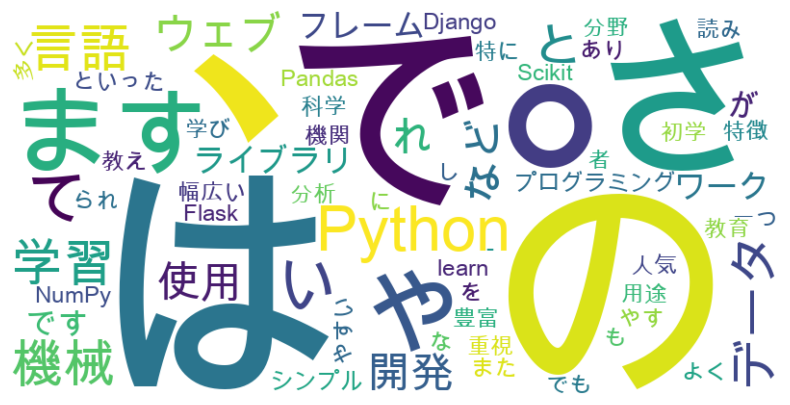

In [67]:
# サンプルテキスト
sample_text = """
Pythonはプログラミング言語の一つで、シンプルさと読みやすさを重視しています。
データ分析や機械学習、ウェブ開発など、幅広い用途で使用されています。
Pythonの特徴は、豊富なライブラリとフレームワークです。
特にデータ科学や機械学習の分野では、PandasやNumPy、Scikit-learnなどのライブラリが人気です。
また、ウェブ開発では、DjangoやFlaskといったフレームワークがよく使用されます。
Pythonは初学者にも学びやすい言語であり、多くの教育機関でも教えられています。
"""

# MeCabの初期化
mecab = MeCab.Tagger('-Ochasen')

# 形態素解析の実行
result = mecab.parse(sample_text)

# 解析結果の処理
word_count = {}  # 単語の出現回数を格納する辞書
for line in result.split('\n'):
    if line == 'EOS' or line == '':
        continue  # EOSまたは空行の場合はスキップ
    parts = line.split('\t')
    word = parts[0]  # 単語を取得
    word_count[word] = word_count.get(word, 0) + 1  # 辞書に単語を追加し、出現回数をカウント

# WordCloud オブジェクトの生成
wordcloud = WordCloud(font_path='/System/Library/Fonts/Supplemental/Arial Unicode.ttf', 
                      background_color='white', width=800, height=400).generate_from_frequencies    (word_count)

# ワードクラウドの表示
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 軸をオフに
plt.show()


In [70]:
text = '吾輩は猫である'
t = MeCab.Tagger('-Ochasen')
result = t.parse(text)
print(result)
result

吾輩	ワガハイ	吾輩	名詞-代名詞-一般		
は	ハ	は	助詞-係助詞		
猫	ネコ	猫	名詞-一般		
で	デ	だ	助動詞	特殊・ダ	連用形
ある	アル	ある	助動詞	五段・ラ行アル	基本形
EOS



'吾輩\tワガハイ\t吾輩\t名詞-代名詞-一般\t\t\nは\tハ\tは\t助詞-係助詞\t\t\n猫\tネコ\t猫\t名詞-一般\t\t\nで\tデ\tだ\t助動詞\t特殊・ダ\t連用形\nある\tアル\tある\t助動詞\t五段・ラ行アル\t基本形\nEOS\n'

In [71]:
result = result.splitlines()
# EOS行は対象外とする
for res in result[:-1]:
    # タブ区切りで分割
    res_split = res.split("\t")
    print(res_split)

['吾輩', 'ワガハイ', '吾輩', '名詞-代名詞-一般', '', '']
['は', 'ハ', 'は', '助詞-係助詞', '', '']
['猫', 'ネコ', '猫', '名詞-一般', '', '']
['で', 'デ', 'だ', '助動詞', '特殊・ダ', '連用形']
['ある', 'アル', 'ある', '助動詞', '五段・ラ行アル', '基本形']


### Bag Of Words

In [2]:
# 形態素解析を行う文書のリスト
documents = ['子供が走る', '車が走る', '子どもの脇を車が走る']

# 各文書の形態素を格納するリスト
morphemes_per_document = []

# MeCabの初期化（Chasen形式で出力）
mecab_tagger = MeCab.Tagger("-Ochasen")

# 各文書に対して形態素解析を実施
for document in documents:
    # 文書を形態素解析
    parsed_document = mecab_tagger.parse(document)
    
    '''
    # 解析結果から形態素のみを抽出してリストに格納
    
    形態素解析が行われた結果はタブ区切りなのでまずタブ区切りで分割し、最初の要素[0]を取得
    splitlines()[:-1]はEOSを無視
    '''
    morphemes = [line.split("\t")[0] for line in parsed_document.splitlines()[:-1]]
    
    # 抽出した形態素のリストを追加
    morphemes_per_document.append(morphemes)

# 結果の表示
print(morphemes_per_document)


[['子供', 'が', '走る'], ['車', 'が', '走る'], ['子ども', 'の', '脇', 'を', '車', 'が', '走る']]


In [4]:
# 対応する辞書を作成する
word2int = {}
i = 0
# 各文書のリストに対して処理を反復する
for words in morphemes_per_document:
    # 文書内の各単語に対応
    for word in words:
        # 単語が辞書に含まれていなければ追加して対応する整数を加える
        if word not in word2int:
            word2int[word] = i
            i += 1
print(word2int)

{'子供': 0, 'が': 1, '走る': 2, '車': 3, '子ども': 4, 'の': 5, '脇': 6, 'を': 7}


In [6]:
print(len(morphemes_per_document),len(word2int))

3 8


In [11]:
# BoWを計算し、文書 x 単語の行列を生成
bow = np.zeros((len(morphemes_per_document),len(word2int)), dtype=int) # 3行8列
# 各行の単語を抽出し単語の出現回数をカウント
for i, words in enumerate(morphemes_per_document):
    for word in words:
        bow[i,word2int[word]] += 1
        
print(bow)

[[1 1 1 0 0 0 0 0]
 [0 1 1 1 0 0 0 0]
 [0 1 1 1 1 1 1 1]]


In [18]:
df = pd.DataFrame(bow, columns=list(word2int))

In [15]:
# 辞書を作成する
word2int_gs = corpora.Dictionary(morphemes_per_document)
print(word2int_gs)

Dictionary<8 unique tokens: ['が', '子供', '走る', '車', 'の']...>


In [16]:
# 単語と整数の対応
print(word2int_gs.token2id)

{'が': 0, '子供': 1, '走る': 2, '車': 3, 'の': 4, 'を': 5, '子ども': 6, '脇': 7}


In [17]:
print(morphemes_per_document[0])
print(word2int_gs.doc2bow(morphemes_per_document[0]))

['子供', 'が', '走る']
[(0, 1), (1, 1), (2, 1)]


In [19]:
df

,子供,が,走る,車,子ども,の,脇,を
0,1,1,1,0,0,0,0,0
1,0,1,1,1,0,0,0,0
2,0,1,1,1,1,1,1,1


In [21]:
# TFとしてBoWを使用
tf = bow
print(tf)

[[1 1 1 0 0 0 0 0]
 [0 1 1 1 0 0 0 0]
 [0 1 1 1 1 1 1 1]]


In [22]:
# IDEを計算
idf = np.log((bow.shape[0] + 1)/(np.sum(bow,axis=0, keepdims=0)+1))
print(idf)

[0.69314718 0.         0.         0.28768207 0.69314718 0.69314718
 0.69314718 0.69314718]


In [23]:
# TF-IDFを計算
tf_idf = tf*(idf + 1)
tf_idf_normalized = tf_idf / np.sqrt(np.sum(tf_idf**2, axis=1, keepdims=True))
print(tf_idf_normalized)

[[0.76749457 0.45329466 0.45329466 0.         0.         0.
  0.         0.        ]
 [0.         0.52284231 0.52284231 0.67325467 0.         0.
  0.         0.        ]
 [0.         0.25712876 0.25712876 0.3311001  0.43535684 0.43535684
  0.43535684 0.43535684]]


### 極性判定

In [ ]:
# 青空文庫の「吾輩は猫である」を読み込む
